# Data Cleaning and EDA

### Import packages and data


In [61]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import descartes


In [122]:
#import training data 
df_train = pd.read_csv('../../../data/raw/train_set_values.csv')
df_labels = pd.read_csv('../../../data/raw/train_set_labels.csv')

#merge labels and features:
df_train= pd.merge(df_train, df_labels, on='id')


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


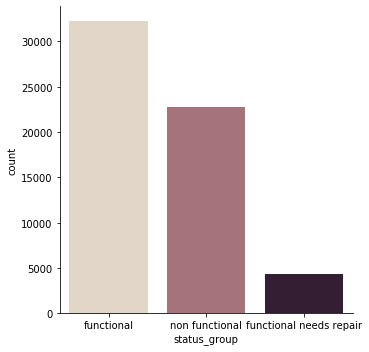

In [63]:
#check the target classes counts:
print(df_train.status_group.value_counts())
sns.catplot(x="status_group", kind="count", palette="ch:.25", data=df_train)

Seems like 'functional' and 'non-functional' are almost balanced enough.... but 'functional needs repair' has a big class inbalance. We'll need to address this later at some point in time... maybe through upsampling, or maybe we could just lump it into non-functional. 

### Clean NaN Values

In [64]:
#find out which features have NAN values. 
df_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

There are many features with NaN values. We'll need to address each of these on a case by case basis as far as what we want to do with the empty values. 

In [65]:
#start with 'scheme_name' since there are so many empty values. 
print(len(df_train.scheme_name.value_counts()))
df_train.scheme_name.value_counts()

2696


K                              682
None                           644
Borehole                       546
Chalinze wate                  405
M                              400
                              ... 
Ushara lawate water supply       1
Kisa                             1
Tove-mtwango                     1
Ngamanga water supply schem      1
BL Mahakamani                    1
Name: scheme_name, Length: 2696, dtype: int64

In [66]:
#According to the feature descriptions this is the same
#as scheme_management, so lets check this:
print(len(df_train.scheme_management.value_counts()))
df_train.scheme_management.value_counts()

12


VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

Ok, scheme_name and scheme_management seem to be different, but because there are over 2669 values for scheme_name and there are 28166 missing values, droping that column will likely not reduce in any loss in predictive power. 

In [67]:
df_train = df_train.drop('scheme_name', axis=1)

In [68]:
#functions to aid in data cleaning

def values_to_keep(df, column, number_of_values_to_keep, verbose = False):
    """
    This function takes in a pandas dataframe, the column of concern, and a number of categories to reduce the number 
    of unique values to. It prints the number of unique values in the column and the top value counts of each. It also
    returns a list of categorical values to retain. 
    """
    number_of_values_to_keep = number_of_values_to_keep-1
    
    if verbose == True:
        print(len(df[column].value_counts()))
        print(df[column].value_counts())
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
    else:
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
        
    return list_of_values_to_keep

def reduce_categorical_values(df, column_name, number_of_values_to_keep):
    
    """
    This function reduces the number of unique categorical values in a specific dataframe's column. It keeps the top 
    'number_of_values_to_keep' values, and casts the other remaining categorical values as "Other". This function 
    returns a Dataframe with the altered categorical values. Using this function can reduce the amount of dummy columns
    needed whilst maintaining the information contained in the column.
    """
    #use helper function to create a list of cat. values to keep
    list_of_classes_to_keep = values_to_keep(df, column_name, number_of_values_to_keep)
    
    #use subsetting to test if cat. value is in list, if not cast it to 'Other'    "~" means isNOTin 
    df[column_name].loc[~df[column_name].isin(list_of_classes_to_keep)]='Other'
    
    return df

def plot_feature(df, pred_col, target_variable, height = 10):
    
    """
    Produces a categorical bar plot visualizing the number of observations in each target category for each predicitve 
    value. 
    """
    
    sns.catplot(y=pred_col, hue=target_variable, kind="count",
            palette="ch:.25", edgecolor=".6",
            data=df, height= height); 



In [69]:
#ok, now lets check the rest in descending order starting with 'funder':
#Lets find the number of categorical values in 'funder', and the top 10 values:
values_to_keep(df_train, 'funder', 10, verbose=True)

1897
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Norplan                      1
Umoja                        1
Ncs                          1
Abdala                       1
Wame Mbiki                   1
Name: funder, Length: 1897, dtype: int64


['Government Of Tanzania',
 'Danida',
 'Hesawa',
 'Rwssp',
 'World Bank',
 'Kkkt',
 'World Vision',
 'Unicef',
 'Tasaf']

'funder' has 1897 unique categories, ~3000 NaN values, but clearly the majority of the water pumps come from a few of the different funders. it doesnt seem right to just fill the NaNs with the mode. There are also way to many to OneHotEncode. Lets instead turn it into 10 categories: the top 9 frequently occuring values,  and one "other" category which will include all other categories + the NaN values.

In [70]:
reduce_categorical_values(df_train, 'funder', 10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Other,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Other,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Other,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Other,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Other,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Other,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,Other,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Other,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


10
Other                     37810
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Tasaf                       877
Name: funder, dtype: int64


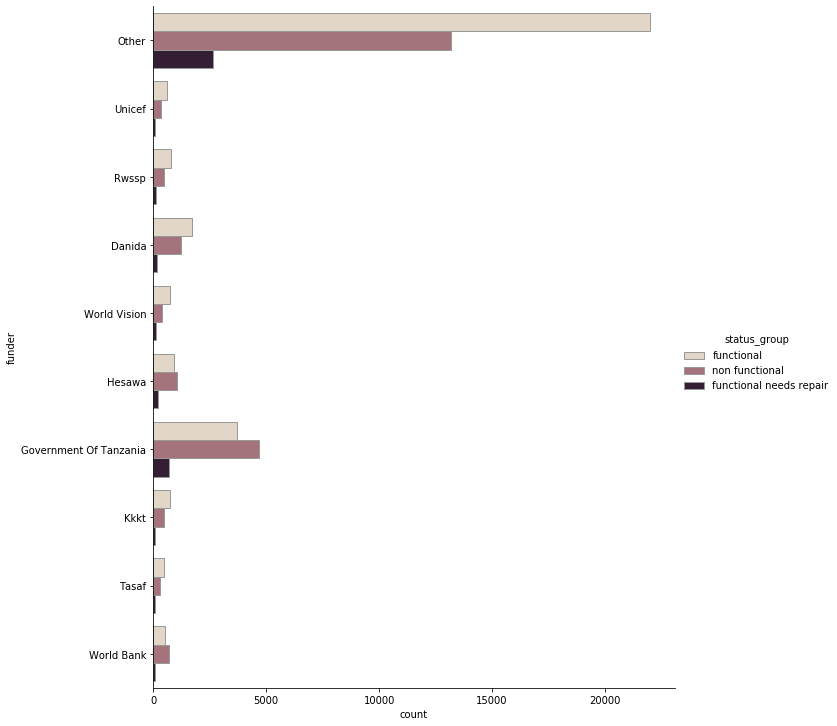

In [71]:
print(len(df_train.funder.value_counts()))
print(df_train.funder.value_counts())
plot_feature(df_train, 'funder', 'status_group')

Looking at the above chart, it seems like funder could be a good predictor sice there are particular funders with significant numbers of disfunctional pumps.  

In [72]:
#Now for 'installer'.Lets find the number of categorical values in 'installer', and the top 10 values:
values_to_keep(df_train, 'installer', 10, verbose= True)


2145
DWE                       17402
Government                 1825
RWE                        1206
Commu                      1060
DANIDA                     1050
                          ...  
Boni                          1
TAIPO                         1
MACK DONALD CONTRSCTOR        1
Mungaya                       1
Msikitini                     1
Name: installer, Length: 2145, dtype: int64


['DWE', 'Government', 'RWE', 'Commu', 'DANIDA', 'KKKT', 'Hesawa', '0', 'TCRS']

In [73]:
#reduce the categorical values of 'installer' to 10, and fill NaN values:
df_train = reduce_categorical_values(df_train, 'installer', 10)

10
Other         33635
DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
KKKT            898
Hesawa          840
0               777
TCRS            707
Name: installer, dtype: int64


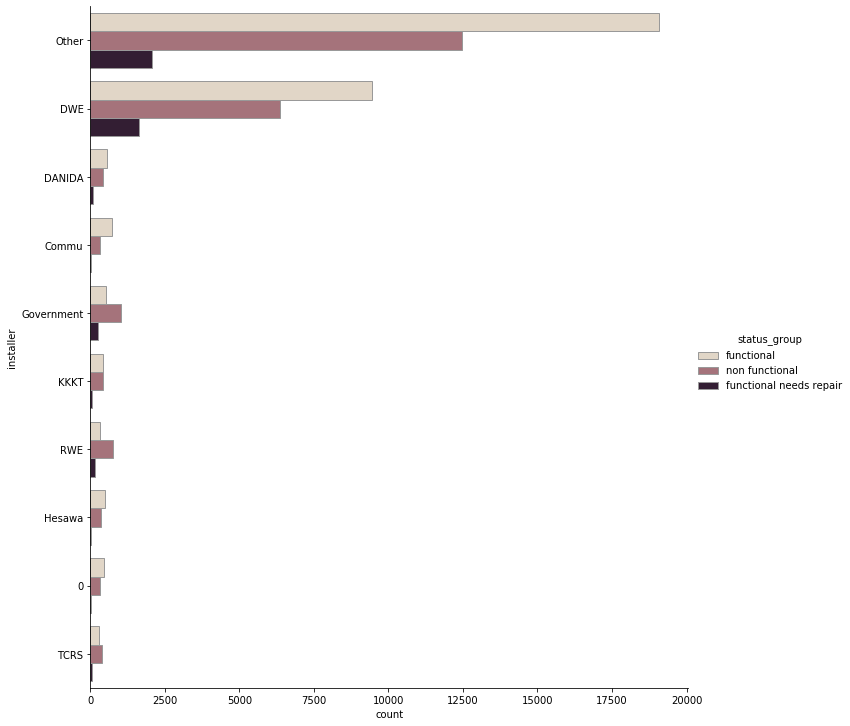

In [74]:
print(len(df_train.installer.value_counts()))
print(df_train.installer.value_counts())
plot_feature(df_train, 'installer', 'status_group')

Looks like installer could be a useful predictor as well! Look at 'Goverment' and 'RWE'. 

In [75]:
#Now for 'subvillage'. Lets find the number of categorical values in 'subvillage', and the top 10 values:
values_to_keep(df_train, 'subvillage', 10, verbose= True)

19287
Madukani       508
Shuleni        506
Majengo        502
Kati           373
Mtakuja        262
              ... 
Bulangale        1
Ndughwila        1
Mwabukwimba      1
Nyalushiha       1
Namali           1
Name: subvillage, Length: 19287, dtype: int64


['Madukani',
 'Shuleni',
 'Majengo',
 'Kati',
 'Mtakuja',
 'Sokoni',
 'M',
 'Muungano',
 'Mbuyuni']

Over 19000 various values! And the top 10 do not seem to have a significant amount of the total distribution, therfore it is highly unlikely that any one of these is great predictor, but just in case lets check the distribution of the top 10. 

10
Other       56494
Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
Sokoni        232
M             187
Muungano      172
Mbuyuni       164
Name: subvillage, dtype: int64


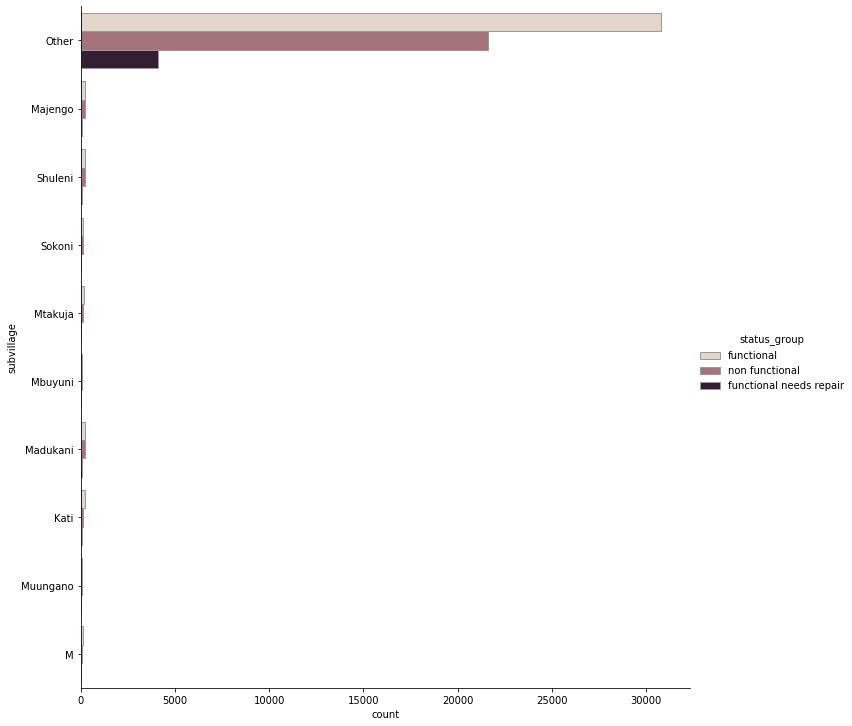

In [76]:
reduce_categorical_values(df_train, 'subvillage', 10)
print(len(df_train.subvillage.value_counts()))
print(df_train.subvillage.value_counts())
plot_feature(df_train, 'subvillage', 'status_group')

Because none of the top 10 villages (not counting 'other') have an overwhelming majority of functioning/nonfunctioning this confirms the previous assumption, the subvillage value is likely to be a poor predictor so we can just drop it.  

In [77]:
df_train = df_train.drop('subvillage', axis=1)

In [78]:
#Now for 'public_meeting'. Lets find the number of categorical values in 'public_meeting'.
values_to_keep(df_train, 'public_meeting', 10, verbose= True)

2
True     51011
False     5055
Name: public_meeting, dtype: int64


[True, False]

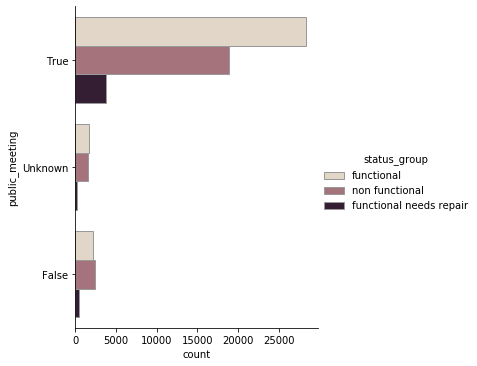

In [79]:
#Replace NaN values with "Unknown" and visualize the predictor's distribution
df_train.public_meeting.fillna(value='Unknown', inplace=True)
plot_feature(df_train, 'public_meeting', 'status_group', height=5)

In [80]:
#Now for 'scheme_management'. Lets find the number of categorical values in 'scheme_management'.
values_to_keep(df_train, 'scheme_management', 10, verbose= True)

12
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64


['VWC',
 'WUG',
 'Water authority',
 'WUA',
 'Water Board',
 'Parastatal',
 'Private operator',
 'Company',
 'Other']

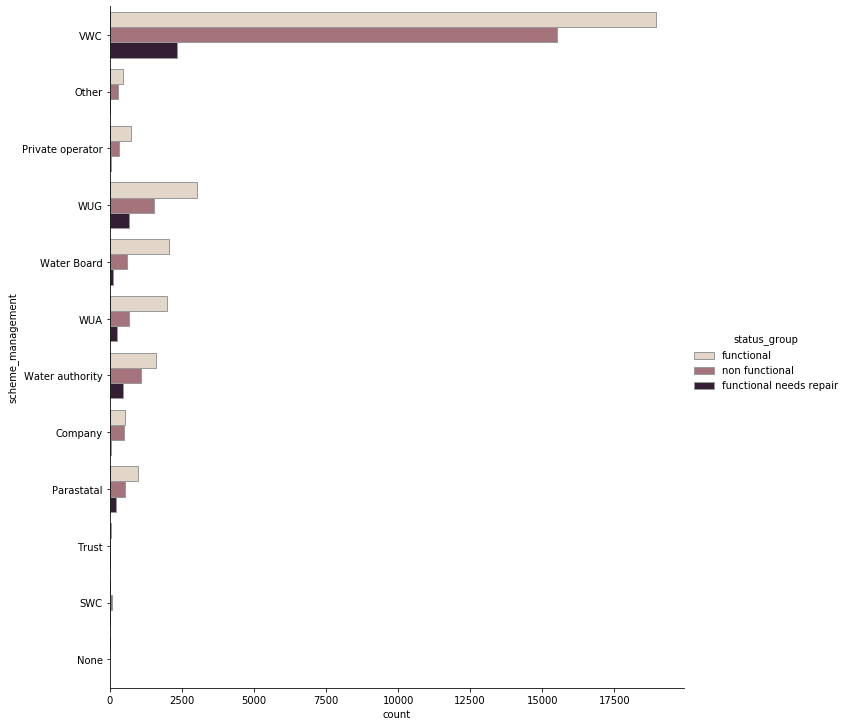

In [81]:
plot_feature(df_train, 'scheme_management', 'status_group')

Because the 10th most frequent value has mostly "non-functioning" wells, it could be a specific and precise predictor. Lets keep it. So, we'll reduce the number of values to 11, and fill in the ~3000 NaN values. 

11
VWC                 36793
WUG                  5206
Other                4644
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64


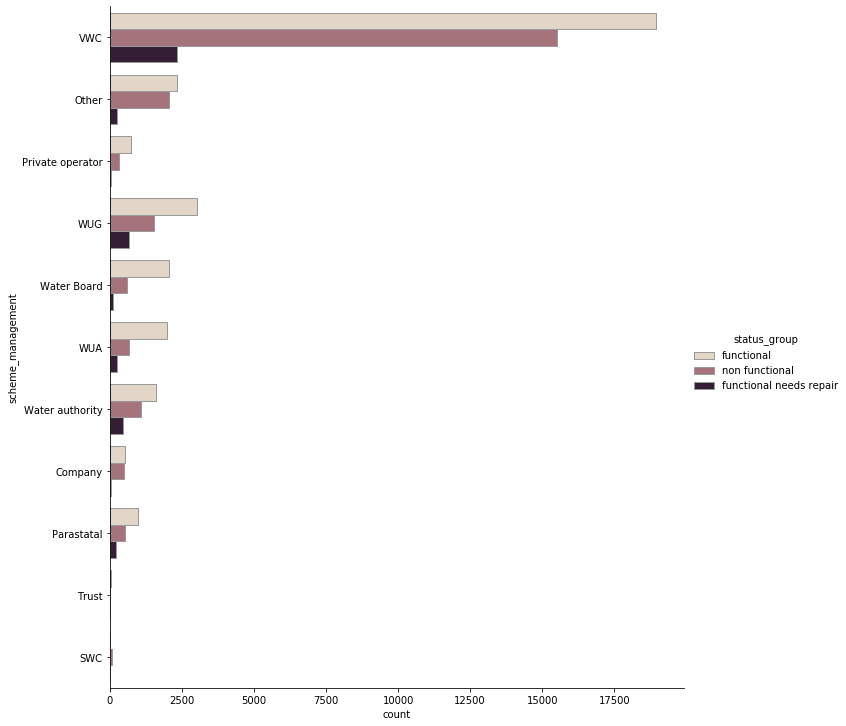

In [82]:

reduce_categorical_values(df_train, 'scheme_management', 12)
print(len(df_train.scheme_management.value_counts()))
print(df_train.scheme_management.value_counts())
plot_feature(df_train, 'scheme_management', 'status_group')

In [83]:
#Now for 'permit'. Lets find the number of categorical values in 'permit':
values_to_keep(df_train, 'permit', 10, verbose= True)

2
True     38852
False    17492
Name: permit, dtype: int64


[True, False]

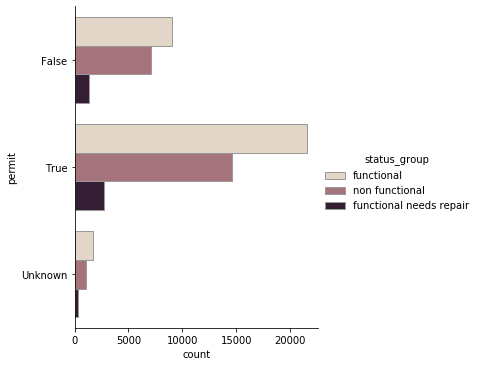

In [84]:
#Another boolean valued category. Let's replace the NaN with 'Unknown'
df_train.permit.fillna(value='Unknown', inplace=True)
plot_feature(df_train, 'permit', 'status_group', height=5)

In [85]:
df_train.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

Great, no more NaN values. Moving on!


### Choosing which columns to keep/drop:

There are still a lot of features. Let's sort through them and drop the less valuable predictors.

I'll be using some intuition here, as well as the data dictionary provided by Driven Data here :

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list


In [86]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 39 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   59400 non-null object
gps_height               59400 non-null int64
installer                59400 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null object
recorded_by              59400 non-null object
s

In [87]:
#id is not likely to be a useful predictor:
df_train = df_train.drop('id', axis=1)

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

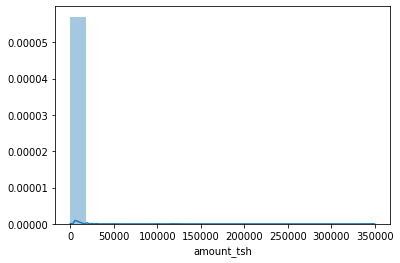

In [88]:
#amount_tsh appears to be a continuous variable. Lets look at the distribution:
sns.distplot(df_train.amount_tsh, bins = 20)
df_train.amount_tsh.value_counts()


The distribution is very skewed. I think that binning this variable could be a good approach in the future after we get a baseline model since very little flow or flow over a certain threshold could be a goood predictor. 

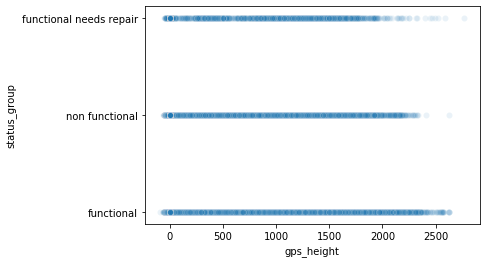

In [89]:
#lets check gps_height.  
sns.scatterplot(y="status_group",x="gps_height", data=df_train, alpha=.09)

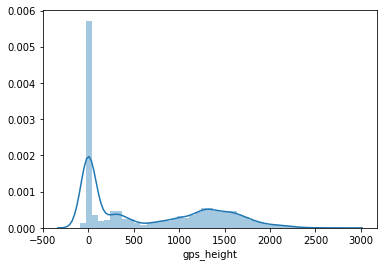

In [90]:
sns.distplot(df_train.gps_height);

Looks like there are below sea level values for GPS height, which after a quick google search, appears to be impossible values. We'll cast below sea level values to equal 0. 

In [91]:
df_train['gps_height'].loc[df_train['gps_height']<0]=0


In [92]:
#We've already looked at installer when dealing with NaN, but installer '0' probably means 'Other' 
#(someone had to install it, even if it is unknown)
df_train.installer.replace(to_replace = '0', value = 'Other', inplace = True)


In [93]:
#wpt_name is not likely to be a useful predictor:
df_train = df_train.drop('wpt_name', axis=1)

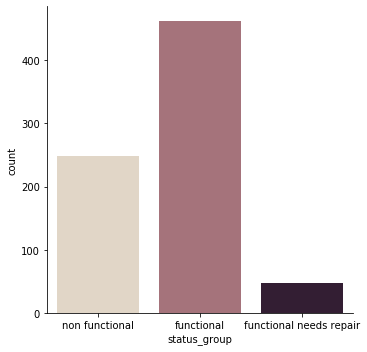

In [94]:
#num_private has no definition on the data dictionary, and is mostly 0 (58643), lets look more into it:
df_train.num_private.value_counts()

#It seems intuitive to assume that 0 means the pump is not private, and any other number means that it is private.
#Using this assumption lets categorize the pumps as 0 and 1, public/private. Lets see if this seems to be at all 
#predictive:
df_train['num_private'].loc[df_train['num_private']>0]=1

#plot the num_private data
df_num_private = df_train[df_train['num_private']==1]
sns.catplot(x = 'status_group', kind = 'count', data=df_num_private, palette='ch:.25')

Though it is very small compared to the overall dataset it does seem that private pumps are more likely to be functional, so we'll keep it as a predictor. 

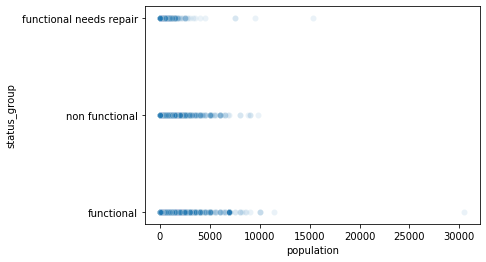

In [95]:
#lets check population around the well. It is a continious variable, and seems like it could be a contributing predictor
#so we'll include it. We may want to scale it later. 
sns.scatterplot(y="status_group",x="population", data=df_train, alpha=.09)


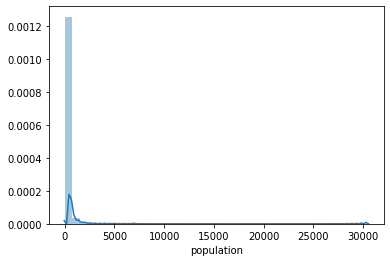

In [96]:
sns.distplot(df_train.population, bins = 40);

In [97]:
#how about recored_by:
values_to_keep(df_train, 'recorded_by', 10, verbose=True)
#All of these pumps were recorded by the same entity, so its a useless predictor, we'll drop it. 
df_train = df_train.drop('recorded_by', axis=1)


1
GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64


In [98]:
#Construction Year:
df_train.construction_year.value_counts();

Construction_year contains 20709 pumps that the year is recorded as '0'. This is a tricky one to deal with, on one 
hand it would be nice to not have to categorize/bin the years (which we would need to do if we cast '0' as 
unknown), on the other hand it doesnt seem like it makes much sense to fill the '0' values with the mean, median, or mode. 

In [99]:
#It probably makes most sense to bin the years. Thanks to 
#'https://github.com/mldataanalysis/Water-Pump-Classification/blob/master/Water%20Pump%201%20-%20EDA%20and%20Data%20Cleaning.ipynb'
#for the useful function to bin years. 

def construction_binner(row):
    """
    This function's main purpose is to address the '0' values in construction_year. 0 is am impossible value for 
    year of construction, so it casts '0' as 'unknown'. Because 'unknown' is not a continuous value, this function
    then bins the years into decades. So, the resulting column is categorical data with decade values. 
    
    This function is meant to be used apart of a df.apply(lambda row:) function as follows
    
    df_train['construction_year'] = df_train.apply(lambda row: construction_binner(row), axis=1)

    """
    
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00'
    elif row['construction_year'] >= 2010:
        return '10'
    else:
        return 'unknown'
    
df_train['construction_year'] = df_train.apply(lambda row: construction_binner(row), axis=1)


In [124]:
#Extraction Type also seems to have 3 redundant colums.
print(df_train.extraction_type.value_counts())
print(df_train.extraction_type_class.value_counts())
print(df_train.extraction_type_group.value_counts())

#lets keep the class, because the more granular categories in the other features are so infrequent it is unlikely to 
#add much more info to the model

df_train = df_train.drop('extraction_type_group', axis=1)
df_train = df_train.drop('extraction_type', axis=1)


gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64
gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono         

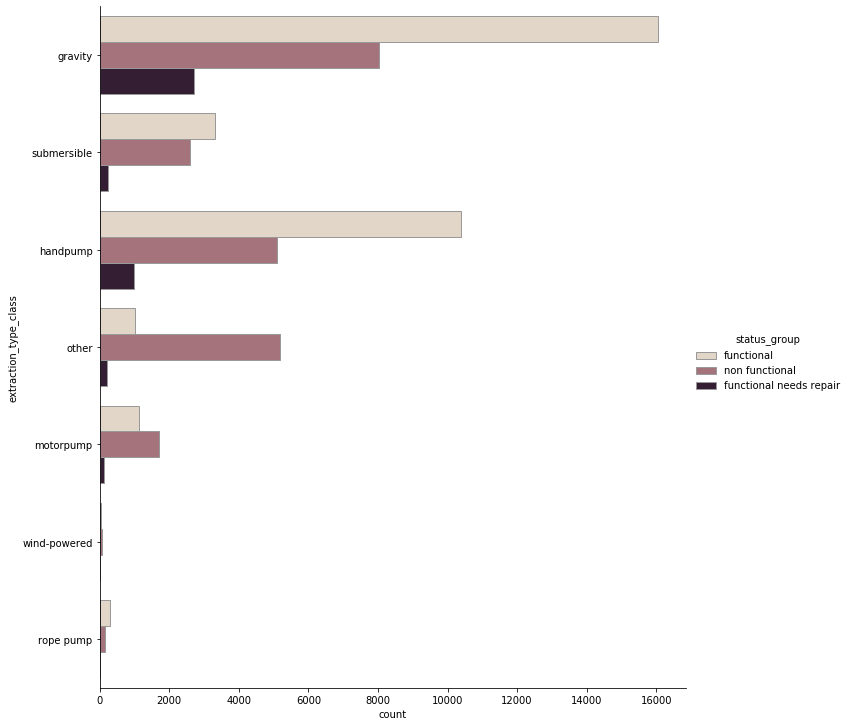

In [126]:
plot_feature(df_train,'extraction_type_class', 'status_group') 


In [101]:
#There are two managment features. Lets choose which to keep, if either:
print(df_train.management.value_counts())
print(df_train.management_group.value_counts())

#lets keep the more granular here:
df_train = df_train.drop('management_group', axis=1)


vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64


In [102]:
#There are two payment features. Lets choose which to keep, if either:
print(df_train.payment.value_counts())
print(df_train.payment_type.value_counts())

#these are totally redundant so we'll drop one. 
df_train = df_train.drop('payment', axis=1)


never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


In [103]:
#There are two water quality features. Lets choose which to keep, if either:
print(df_train.water_quality.value_counts())
print(df_train.quality_group.value_counts())

#lets choose the less granular to avoid overfitting:
df_train = df_train.drop('water_quality', axis=1)



soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


In [104]:
#There are two quantity features. Lets choose which to keep, if either:
print(df_train.quantity.value_counts())
print(df_train.quantity_group.value_counts())

#once again totally redundant
df_train = df_train.drop('quantity', axis=1)


enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


In [105]:
#There are three source features. Lets choose which to keep, if any:
print(df_train.source.value_counts())
print(df_train.source_class.value_counts())
print(df_train.source_type.value_counts())

#lets choose the source_class feature, which is the middle between too general and too granular:
df_train = df_train.drop('source', axis=1)
df_train = df_train.drop('source_type', axis=1)


spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64
groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64


In [106]:
#There are two water point features. Lets choose which to keep, if any:
print(df_train.waterpoint_type.value_counts())
print(df_train.waterpoint_type_group.value_counts())

#lets choose the one that does not differentiate between single and multiple communal standpipes:
df_train = df_train.drop('waterpoint_type', axis=1)


communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


### Geographic Features

Now lets look at the geography of the wells and see if we can make use of their predictive power somehow:

Great tutorial on plotting point features with geogpandas here: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

In [107]:
def map_pumps(df_train):
    """
    This function maps the pumps, with their status, across Tanzania.
    You must install/import the following libraries:
    
        import geopandas as gpd
        from shapely.geometry import Point, Polygon
        import matplotlib.pyplot as plt
        import descartes
    """
                  
    #import a Tanzania shape files
    tanz_base = gpd.read_file('../../../data/raw/geographic/tza_admbnda_adm0_20181019.shp')
    regions = gpd.read_file('../../../data/raw/geographic/tza_admbnda_adm1_20181019.shp')
    ward = gpd.read_file('../../../data/raw/geographic/tza_admbnda_adm2_20181019.shp')
    county = gpd.read_file('../../../data/raw/geographic/tza_admbnda_adm3_20181019.shp')

    #set the WGS84 projection
    crs = {'init':'espg:4326'}

    #create geometric points for projecting
    geometry = [Point(xy) for xy in zip( df_train['longitude'], df_train['latitude'])]
    geo_df_train = gpd.GeoDataFrame(df_train, crs = crs, geometry = geometry)
    df_train = df_train.drop('geometry', axis=1)

    #remove geographic outliers/NaNs for visualization clarity 
    #(there were ~1800 points with longitude = 0 (Earlier test-mapping showed this))
    geo_df_train = geo_df_train[geo_df_train.longitude != 0]

    #plot the points over the Tanz base map
    fig,ax = plt.subplots(figsize = (25,25))
    # tanz_base.plot(ax = ax, alpha = .4, color = 'grey')
    ward.plot(ax=ax, color = 'grey', alpha = .2, linewidth=1, edgecolor = 'black')
    geo_df_train[geo_df_train['status_group']=='functional'].plot(ax = ax, markersize = 10, 
                                                                  color = 'blue', alpha = .1, marker = 'o', 
                                                                  label = 'functional')
    geo_df_train[geo_df_train['status_group']=='non functional'].plot(ax = ax, markersize = 10, 
                                                                      color = 'red', alpha = .1, marker = 'o', 
                                                                      label = 'non functional')
    geo_df_train[geo_df_train['status_group']=='functional needs repair'].plot(ax = ax, markersize = 10,
                                                                               color = 'yellow', alpha = .5, marker = 'o', 
                                                                        label = 'functional needs repair')
    plt.title('Water Pumps Across Tanzania',fontdict=
                              {'fontsize': 25})
                            
    plt.legend(prop = {'size':25}, markerscale=5)
    plt.savefig("../../../reports/figures/pump_geo_distribution.png", dpi=300)
    plt.show()
    

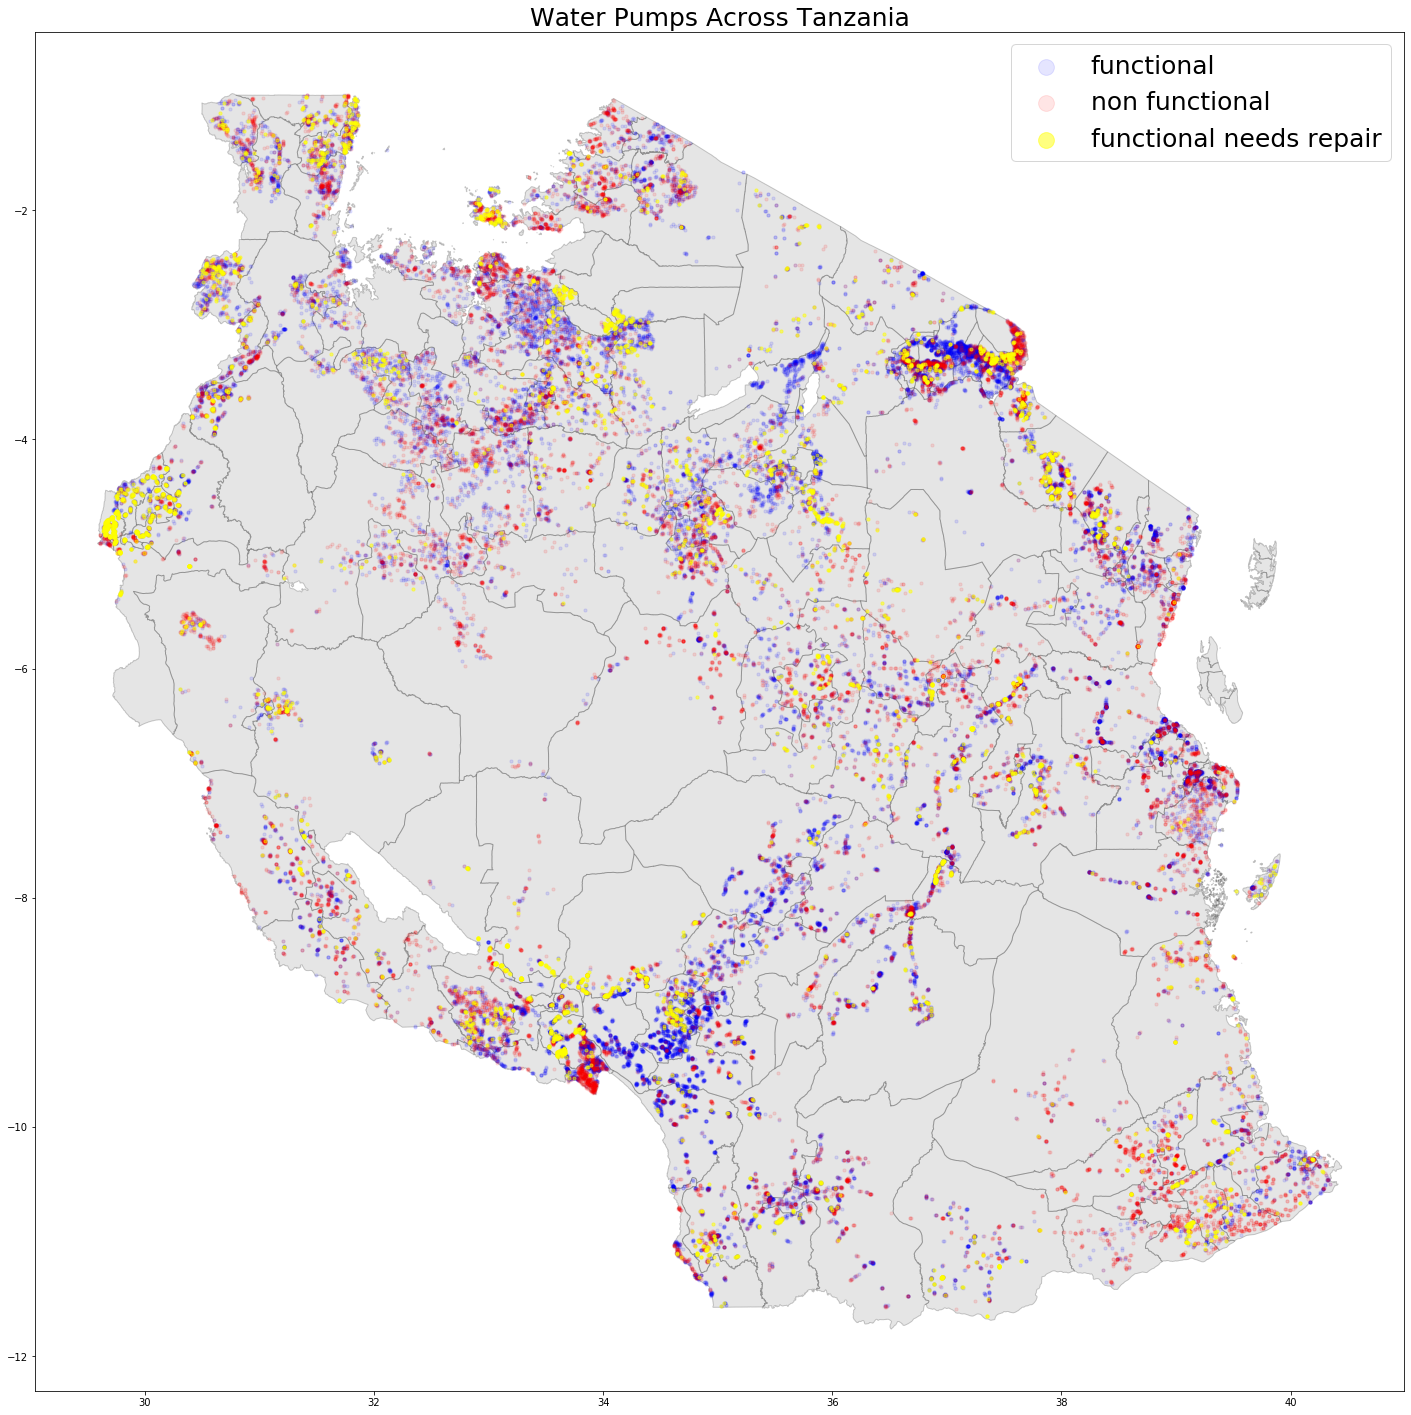

In [108]:
map_pumps(df_train)

In [109]:
import rasterio
import rasterio.plot
import matplotlib.colors as colors

def pop_den_raster():
    """
    This function maps the Tanzania Populatin Density, people per 100m, across Tanzania.
    You must install/import the following libraries:
    
    import rasterio
    import rasterio.plot
    import matplotlib.colors as colors
    """

    # countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    raster = rasterio.open('../../../data/raw/geographic/TZA_popmap15adj_v2b.tif')

    fig, ax = plt.subplots(figsize=(15, 15))
    rasterio.plot.show(raster, title='Tanzania Population Density \n 100m Resolution', ax=ax, cmap='Blues', norm = colors.LogNorm(vmin=.01, vmax=393))
    plt.savefig("../../../reports/figures/pop_den_map.png", dpi=300)

    plt.show()

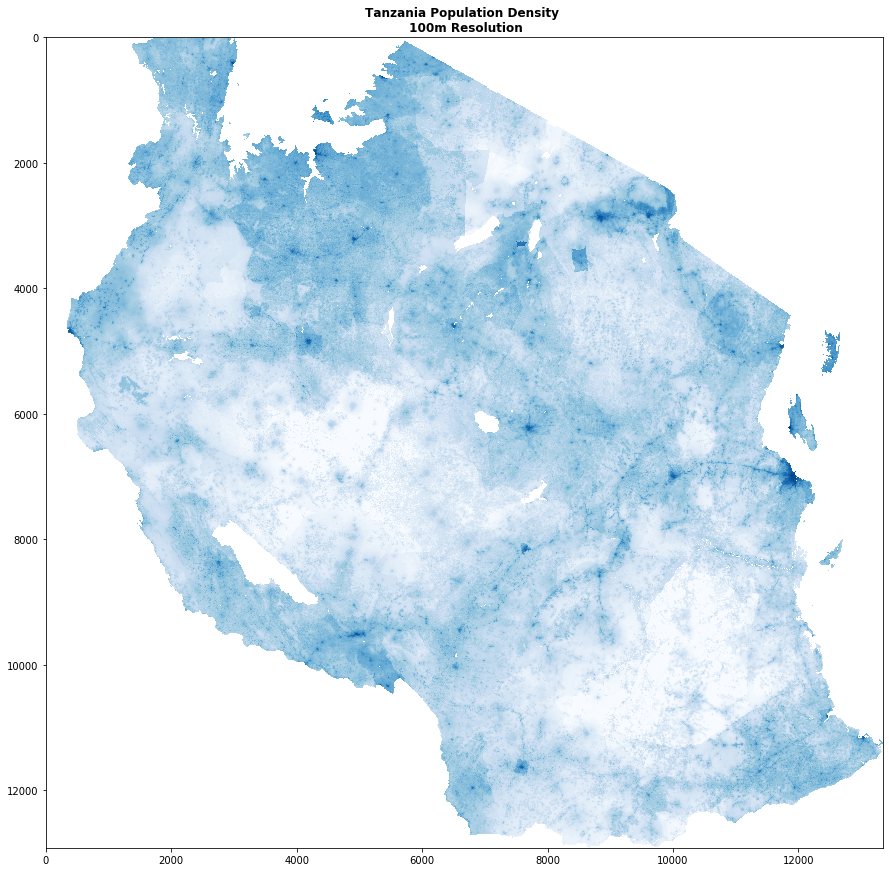

In [110]:
pop_den_raster()

There does look to be a possible geographic clustering. For example, in the southern part of the country there are several obvious clusters of red, and in the center of the country blue seems to dominate. They likey correlate most with population distribution, however there could be something else here such as distance from a big city. Using the other geographic features in the dataset may account for these types of correlations, however this could be something to expolore later. If we have time this could be a good stretch goal.

In [111]:
#investigate the other geographical features:

print(df_train.region.value_counts())
print(df_train.region_code.value_counts())
print(df_train.district_code.value_counts())
print(df_train.lga.value_counts())
print(df_train.ward.value_counts())





Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64
11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64
1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62

At this time, lets drop Lat, Long, ward, district, region_code, and lga; and we'll keep region.



In [112]:
df_train = df_train.drop(['lga', 'ward', 'district_code','region_code','latitude', 'longitude'], axis=1)


### Datetime


In [113]:
df_train.date_recorded.describe()

count          59400
unique           356
top       2011-03-15
freq             572
Name: date_recorded, dtype: object

In [114]:
#Lets tranform date_recorded into a continuous variable with some sort of potential, such as days since the earliest recordgin

#convert to datetime
df_train.date_recorded = pd.to_datetime(df_train.date_recorded)

#subtract the minimum (oldest date) to get days since first recording
df_train['days_since']=df_train.date_recorded-df_train.date_recorded.min()

#days_since is timedelta64[ns] so we cast it to int64 and dived it by # of ns in day:
df_train['days_since']=df_train['days_since'].astype(int)/(8.64e+13)

#drop date_recorded:
df_train = df_train.drop('date_recorded', axis=1)


### Functionalize the above cleaning:

In [115]:
def import_pump_data():
    #import training data 
    df_train = pd.read_csv('../../../data/raw/train_set_values.csv')
    df_labels = pd.read_csv('../../../data/raw/train_set_labels.csv')
    

    #merge labels and features:
    df_train= pd.merge(df_train, df_labels, on='id')
    
    return df_train

def values_to_keep(df, column, number_of_values_to_keep, verbose = False):
    """
    This function takes in a pandas dataframe, the column of concern, and a number of categories to reduce the number 
    of unique values to. It prints the number of unique values in the column and the top value counts of each. It also
    returns a list of categorical values to retain. 
    """
    number_of_values_to_keep = number_of_values_to_keep-1
    
    if verbose == True:
        print(len(df[column].value_counts()))
        print(df[column].value_counts())
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
    else:
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
        
    return list_of_values_to_keep


def reduce_categorical_values(df, column_name, number_of_values_to_keep):
    
    """
    This function reduces the number of unique categorical values in a specific dataframe's column. It keeps the top 
    'number_of_values_to_keep' values, and casts the other remaining categorical values as "Other". This function 
    returns a Dataframe with the altered categorical values. Using this function can reduce the amount of dummy columns
    needed whilst maintaining the information contained in the column.
    """
    #use helper function to create a list of cat. values to keep
    list_of_classes_to_keep = values_to_keep(df, column_name, number_of_values_to_keep)
    
    #use subsetting to test if cat. value is in list, if not cast it to 'Other'    "~" means isNOTin 
    df[column_name].loc[~df[column_name].isin(list_of_classes_to_keep)]='Other'
    
    return df
    

def cols_to_drop():
    """
    This small helper function creates a list of columns to be dropped by future functions.
    
    The columns selected to drop have logic behind the decision. Please see the jupyter notebook:
    ../../notebooks/Exploratory/Brent/Eda_cleaning/ for the detailed logic behind the feature selection. 
    
    """
    cols_to_drop = ['scheme_name','subvillage','id','wpt_name','recorded_by','extraction_type_group',
                    'extraction_type','management_group','payment','water_quality','quantity','source','source_type',
                   'waterpoint_type', 'lga', 'ward', 'district_code','region_code','latitude', 'longitude']
    return cols_to_drop


def drop_features(df, list_of_columns):
    """
    This function drops columns included in list_of_columns
    """
    
    df = df.drop(list_of_columns, axis =1)
    return df

def simplify_categorical_features(df):
    """
    This function simplifies all of the features that have many categorical values in preperation for OneHotEncoding,
    and in the process also cleans up some NaN values.
    
    Each feature's simplification has logic behind it. Please see the jupyter notebook:
    ../../notebooks/Exploratory/Brent/Eda_cleaning/ for the detailed logic behind the simplification.
    """
    
    df = reduce_categorical_values(df, 'funder', 10)
    df = reduce_categorical_values(df, 'installer', 10)
    df = reduce_categorical_values(df, 'scheme_management', 12)
    return df

def construction_binner(row):
    """
    This function's main purpose is to address the '0' values in construction_year. 0 is am impossible value for 
    year of construction, so it casts '0' as 'unknown'. Because 'unknown' is not a continuous value, this function
    then bins the years into decades. So, the resulting column is categorical data with decade values. 
    
    This function is meant to be used apart of a df.apply(lambda row:) function as follows
    
    df_train['construction_year'] = df_train.apply(lambda row: construction_binner(row), axis=1)

    """
    
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00'
    elif row['construction_year'] >= 2010:
        return '10'
    else:
        return 'unknown'

def fill_nans(df):
    """
    This function cleans up NaN values that still remain, and adjusts impossible values, and categorizes the private 
    well feature. 
    
    Each feature's NaN value imputation has logic behind it. Please see the jupyter notebook:
    ../../notebooks/Exploratory/Brent/Eda_cleaning/ for the detailed logic behind the imputation.
    """
    df.public_meeting.fillna(value='Unknown', inplace=True)
    df.permit.fillna(value='Unknown', inplace=True)
    df.installer.replace(to_replace = '0', value = 'Other', inplace = True)
                  
    #account for the impossible year of construction values using contruction_binner function
    df['construction_year'] = df.apply(lambda i: construction_binner(i), axis=1)

    #categorize private wells as private, or public:
    df['num_private'].loc[df['num_private']>0]=1
     
    #remove impossible values from gps_height
    df_train['gps_height'].loc[df_train['gps_height']<0]=0

    return df

def date_time_transform(df):
    """
    This function transforms the date time features in preperation for modeling.
       
    Please see the jupyter notebook: ../../notebooks/Exploratory/Brent/Eda_cleaning/ 
    for the detailed logic behind the handling of date features.
    """

    df.date_recorded = pd.to_datetime(df.date_recorded)
    df['days_since']=df.date_recorded-df.date_recorded.min()
    df['days_since']=df['days_since'].astype(int)/(8.64e+13)
    df = df.drop('date_recorded', axis=1)
    return df
                  


Now, combine the above helper functions into one larger cleaning data function:


In [116]:
def clean_all_data(df):
    """
    This function utilizes the helper functions to complete all of the cleaning.
    """
    
    list_of_columns = cols_to_drop()
    df = drop_features(df, list_of_columns)
    df = simplify_categorical_features(df)
    df = fill_nans(df)
    cleaned_df = date_time_transform(df)
    return cleaned_df

### OneHotEncode categorical variables:

In [117]:
def encode_data(df):
    """
    Use pd.getdummies to onehot encode categorical data. Returns two dataframes : dummy_df and target. 
    """
    target = df.status_group
    df = df.drop('status_group', axis=1)

    cat_feats = ['funder','installer', 'num_private',
           'region','public_meeting', 'scheme_management', 'permit',
           'construction_year', 'extraction_type_class', 'management',
           'payment_type', 'quality_group', 'quantity_group', 'source_class',
           'waterpoint_type_group', 'basin']

    dum_df = pd.get_dummies(df, columns = cat_feats)
    return dum_df, target 


In [118]:
df_train = import_pump_data()
df_train = clean_all_data(df_train)
dum_df, target = encode_data(df_train)

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Export the cleaned and OHE data:

In [119]:
import pickle 

with open("pump_predictors_data_cleaned.pickle", "wb") as f: # "wb" means "write as bytes"
    pickle.dump(dum_df, f)

In [120]:
with open("pump_target_data_cleaned.pickle", "wb") as f: # "wb" means "write as bytes"
    pickle.dump(target, f)